# EDA (Exploratory Data Analysis)

In [4]:
import pandas as pd

file_path = r"C:\Users\grove\Desktop\advanced_synthetic_investor_data.csv"
data = pd.read_csv(file_path)

print(data.head())

print(data.info())

                            Investor_ID                     Name  Age  \
0  36b438c4-90bc-40be-b967-c7aaa86458cb             Justin Rubio   48   
1  8801af1c-a5dd-4b71-86d3-60ed1555611e         Christina Dodson   52   
2  94621b72-4826-4fbb-86c8-d69dfdf4f2c8  Mr. Christopher Shannon   35   
3  f9ca5157-e05d-4e67-9f52-9a205fde4686           Michael Torres   59   
4  6178bbd7-79c3-4241-a5d7-0d41ec9dd2c1             Louis Hanson   59   

                            Country Income_Level Risk_Tolerance  \
0                              Iran         High           High   
1  Saint Vincent and the Grenadines         High            Low   
2                           Lebanon          Low         Medium   
3                           Moldova         High            Low   
4                             Aruba       Medium           High   

  Preferred_Investment  Portfolio_Value  Risk_Adjusted_Returns (%)  \
0       Cryptocurrency          2387298                  238729.80   
1          Hedge F

In [8]:
import pymysql

# Database connection details
db_user = "root"
db_password = "ImbHrls92%$"
db_host = "localhost"

# Connect to MySQL
connection = pymysql.connect(
    host=db_host,
    user=db_user,
    password=db_password
)

cursor = connection.cursor()


cursor.execute("CREATE DATABASE IF NOT EXISTS investor_data;")
print("Database 'investor_data' created successfully.")


cursor.close()
connection.close()


Database 'investor_data' created successfully.


In [2]:
import pandas as pd
from sqlalchemy import create_engine
import pymysql


db_user = "root"
db_password = "ImbHrls92%$"
db_host = "localhost"
db_name = "investor_data"
table_name = "investors"

# File path
file_path = r"C:\Users\grove\Desktop\advanced_synthetic_investor_data.csv"


data = pd.read_csv(file_path)

# Step 2: Handle Missing Values

data.fillna({
    "Age": 0,  # Assuming 0 for missing age, this can be adjusted based on the use case
    "Portfolio_Value": 0,
    "Net_Worth": 0,
    "Risk_Adjusted_Returns (%)": 0.0
}, inplace=True)


data.dropna(subset=["Investor_ID", "Name", "Date_Joined"], inplace=True)

# Step 3: Rename Columns to SQL-Compliant Format
data.columns = [col.replace(" ", "_").replace("%", "Percent") for col in data.columns]

# Step 4: Validate and Standardize Date Formats

data['Date_Joined'] = pd.to_datetime(data['Date_Joined'], errors='coerce')
data.dropna(subset=["Date_Joined"], inplace=True)

# Step 5: Remove Duplicates

data.drop_duplicates(subset=["Investor_ID"], inplace=True)

# Step 6: Handle Outliers
# Example: Remove unrealistic ages or net worths
data = data[(data['Age'] >= 18) & (data['Age'] <= 100)]  # Assuming valid age range is 18-100
data = data[data['Net_Worth'] >= 0]  # Ensure net worth is non-negative
data = data[data['Portfolio_Value'] >= 0]  # Ensure portfolio value is non-negative

# Step 7: Feature Engineering

age_bins = [0, 25, 40, 60, 100]
age_labels = ["18-25", "26-40", "41-60", "60+"]
data['Age_Group'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels, right=False)

# Example: Add a Portfolio to Net Worth Ratio
data['Portfolio_to_Net_Worth_Ratio'] = data['Portfolio_Value'] / data['Net_Worth']
data['Portfolio_to_Net_Worth_Ratio'] = data['Portfolio_to_Net_Worth_Ratio'].fillna(0)

# Step 8: Domain-Specific Checks

if "Email" in data.columns:
    data = data[data["Email"].str.contains(r"^[\w\.-]+@[\w\.-]+\.\w+$", na=False)]

# Logical consistency check: Portfolio Value ≤ Net Worth
data = data[data['Portfolio_Value'] <= data['Net_Worth']]

# Step 9: Connect to MySQL and Create Database/Table
try:
   
    connection = pymysql.connect(host=db_host, user=db_user, password=db_password)
    cursor = connection.cursor()
    cursor.execute(f"CREATE DATABASE IF NOT EXISTS {db_name};")
    connection.commit()
    cursor.close()
    connection.close()
    print(f"Database '{db_name}' ensured to exist.")

   
    connection_string = f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_name}"
    engine = create_engine(connection_string)

   
    data.to_sql(name=table_name, con=engine, if_exists="replace", index=False)
    print(f"Data uploaded successfully to table '{table_name}' in database '{db_name}'.")
except Exception as e:
    print(f"Error: {e}")
    
    
   
updated_file_path = r"C:\Users\grove\Desktop\updated_investor_data.csv"


try:
    data.to_csv(updated_file_path, index=False)
    print(f"Updated data successfully saved to '{updated_file_path}'")
except Exception as e:
    print(f"Error saving updated data: {e}")



Database 'investor_data' ensured to exist.
Data uploaded successfully to table 'investors' in database 'investor_data'.
Updated data successfully saved to 'C:\Users\grove\Desktop\updated_investor_data.csv'


# Advanced Analysis 

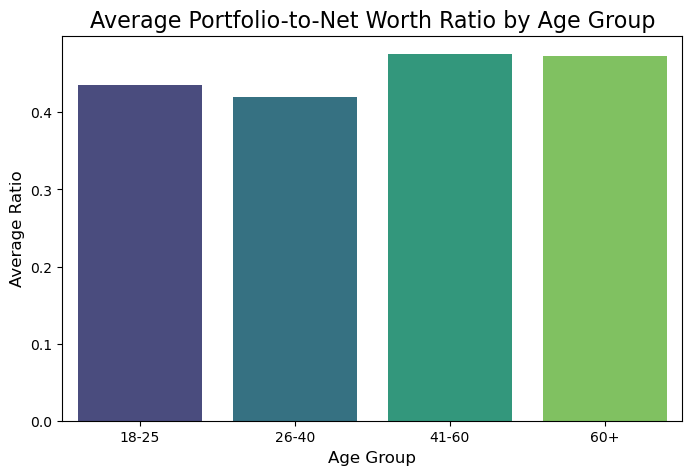

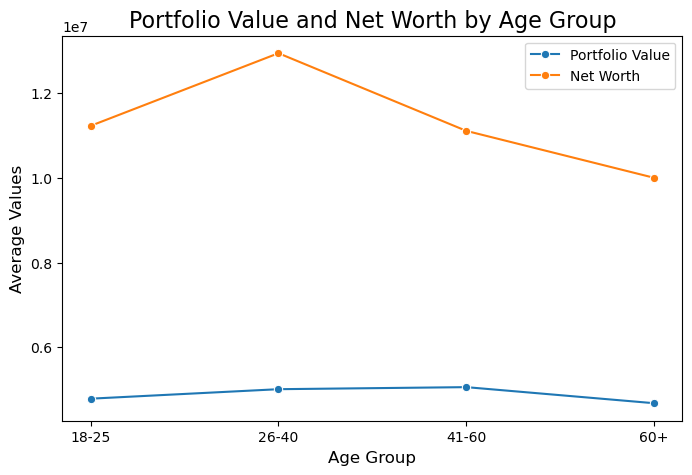

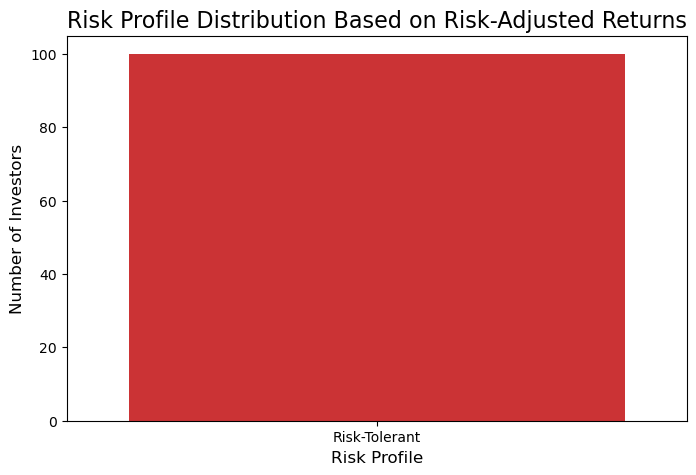

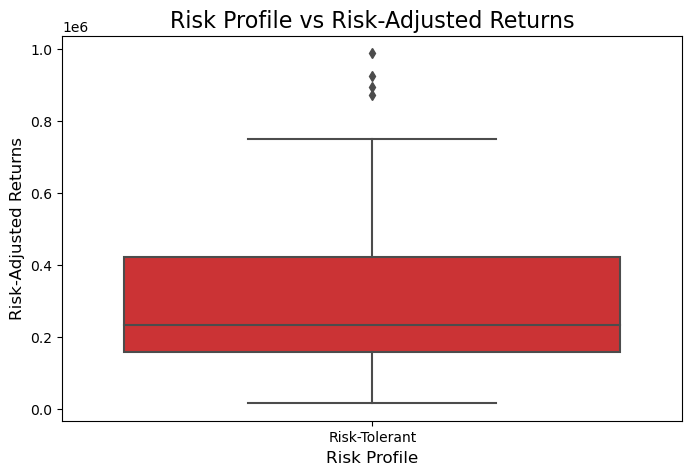

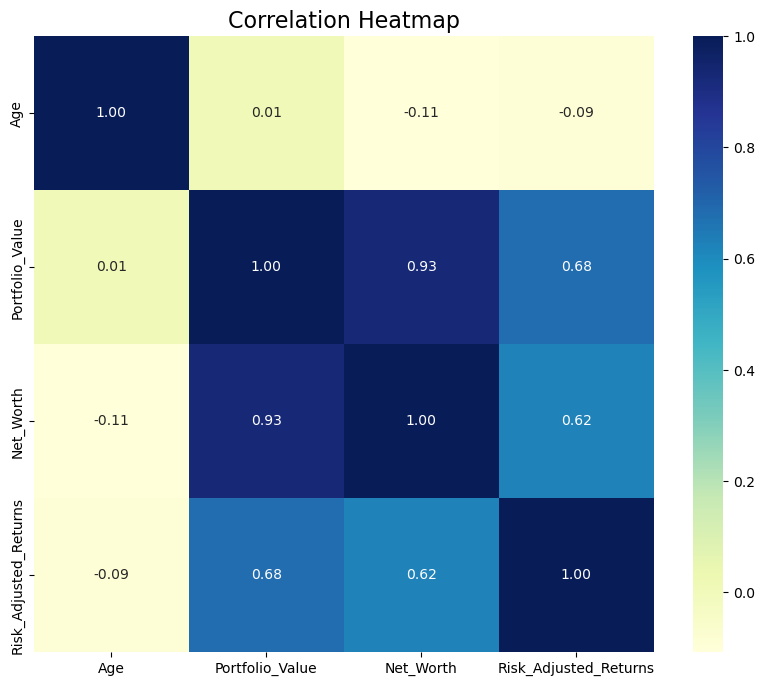

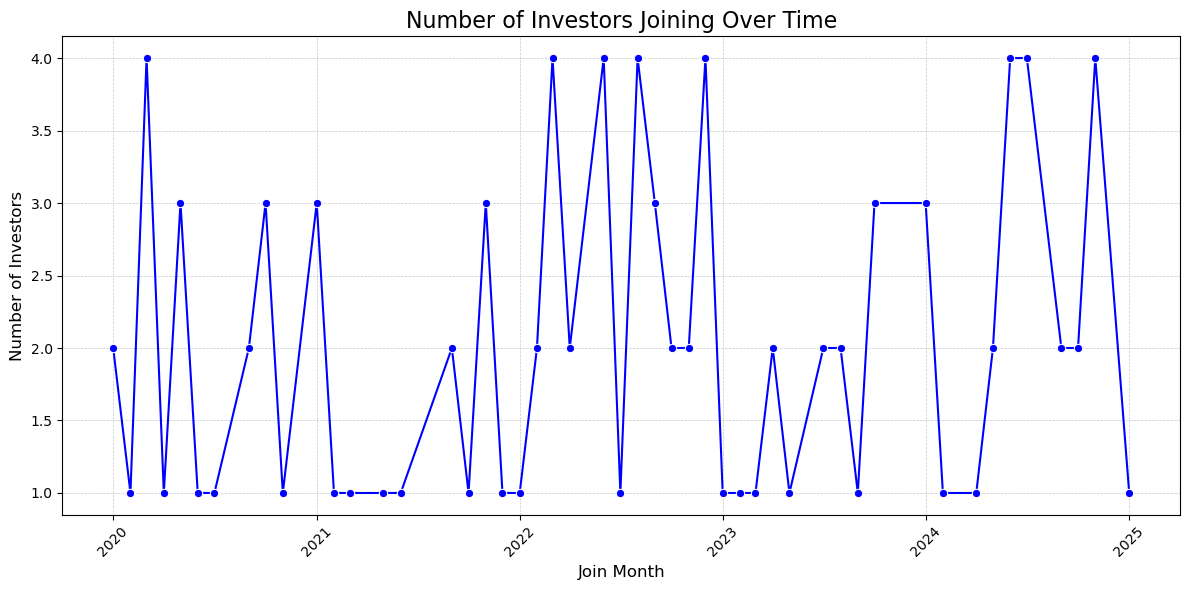

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt


db_user = "root"
db_password = "ImbHrls92%$"
db_host = "localhost"
db_name = "investor_data"
table_name = "investors"


connection_string = f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_name}"
engine = create_engine(connection_string)

# 1. Portfolio Performance Segmentation
query1 = """
SELECT Age_Group, 
       AVG(Portfolio_to_Net_Worth_Ratio) AS Avg_Ratio, 
       COUNT(*) AS Investor_Count
FROM investors
GROUP BY Age_Group
ORDER BY Age_Group;
"""
portfolio_performance = pd.read_sql(query1, engine)

# Visualization: Portfolio-to-Net-Worth Ratio by Age Group
plt.figure(figsize=(8, 5))
sns.barplot(data=portfolio_performance, x="Age_Group", y="Avg_Ratio", palette="viridis")
plt.title("Average Portfolio-to-Net Worth Ratio by Age Group", fontsize=16)
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Average Ratio", fontsize=12)
plt.show()

# 2. Age Group Analysis
query2 = """
SELECT Age_Group, 
       AVG(Portfolio_Value) AS Avg_Portfolio_Value, 
       AVG(Net_Worth) AS Avg_Net_Worth
FROM investors
GROUP BY Age_Group
ORDER BY Age_Group;
"""
age_group_analysis = pd.read_sql(query2, engine)

# Visualization: Portfolio Value and Net Worth by Age Group
plt.figure(figsize=(8, 5))
sns.lineplot(data=age_group_analysis, x="Age_Group", y="Avg_Portfolio_Value", label="Portfolio Value", marker="o")
sns.lineplot(data=age_group_analysis, x="Age_Group", y="Avg_Net_Worth", label="Net Worth", marker="o")
plt.title("Portfolio Value and Net Worth by Age Group", fontsize=16)
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Average Values", fontsize=12)
plt.legend()
plt.show()

# 3. Risk-Adjusted Returns Segmentation
query3 = """
SELECT Age, Portfolio_Value, Net_Worth, Risk_Adjusted_Returns,Preferred_Investment, Liquidity_Preference
FROM investors;
"""

correlation_data = pd.read_sql(query3, engine)

# Categorize investors based on Risk-Adjusted Returns
correlation_data['Risk_Profile'] = correlation_data['Risk_Adjusted_Returns'].apply(
    lambda x: 'Risk-Tolerant' if x > 0.5 else 'Risk-Averse'
)

# Visualization: Risk Profile Distribution with Distinct Colors
plt.figure(figsize=(8, 5))
sns.countplot(data=correlation_data, x="Risk_Profile", palette="Set1")  # Using Set1 palette for better distinction
plt.title("Risk Profile Distribution Based on Risk-Adjusted Returns", fontsize=16)
plt.xlabel("Risk Profile", fontsize=12)
plt.ylabel("Number of Investors", fontsize=12)
plt.show()



# Risk Profile vs Risk-Adjusted Returns (Boxplot)
plt.figure(figsize=(8, 5))
sns.boxplot(data=correlation_data, x="Risk_Profile", y="Risk_Adjusted_Returns", palette="Set1")
plt.title("Risk Profile vs Risk-Adjusted Returns", fontsize=16)
plt.xlabel("Risk Profile", fontsize=12)
plt.ylabel("Risk-Adjusted Returns", fontsize=12)
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = correlation_data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

# Trend Analysis

query4 = """
SELECT 
    DATE_FORMAT(Date_Joined, '%%Y-%%m') AS Join_Month, 
    COUNT(*) AS Investor_Count
FROM investors
GROUP BY Join_Month
ORDER BY Join_Month;
"""

# Fetching the data
try:
    trend_analysis = pd.read_sql(query4, engine)

    # Ensure Join_Month is parsed as datetime
    trend_analysis['Join_Month'] = pd.to_datetime(trend_analysis['Join_Month'])
    trend_analysis = trend_analysis.sort_values(by='Join_Month')

    
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=trend_analysis, x="Join_Month", y="Investor_Count", marker="o", color="blue")
    plt.title("Number of Investors Joining Over Time", fontsize=16)
    plt.xlabel("Join Month", fontsize=12)
    plt.ylabel("Number of Investors", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error: {e}")
    
    






# Clustering

In [27]:
print(correlation_data.columns)

Index(['Age', 'Portfolio_Value', 'Net_Worth', 'Risk_Adjusted_Returns',
       'Risk_Profile'],
      dtype='object')


Columns found. Proceeding with preprocessing.


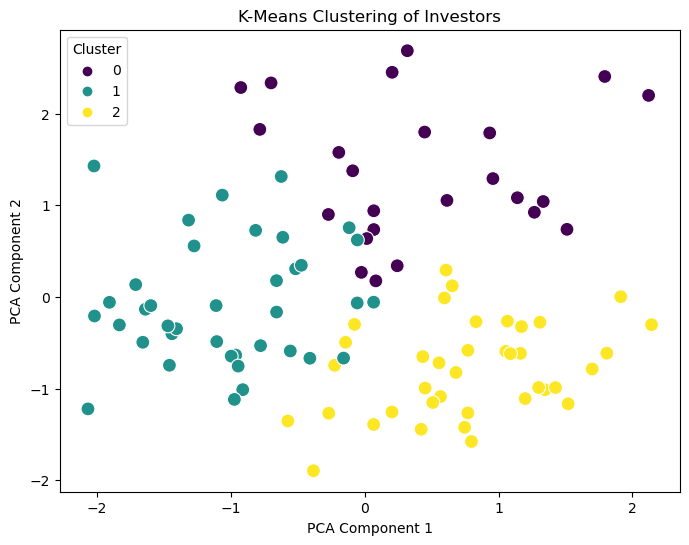

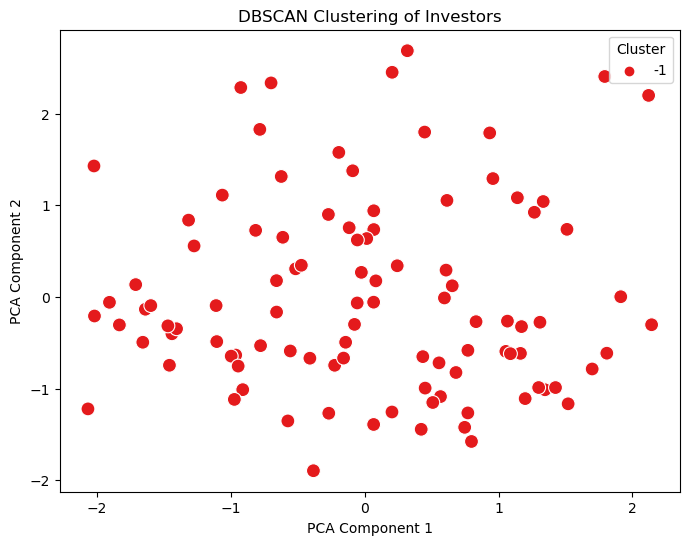

K-Means Cluster Statistics:
                Risk_Adjusted_Returns        Age  Preferred_Investment  \
KMeans_Cluster                                                           
0                       620850.354167  38.125000              2.000000   
1                       218511.700263  55.789474              2.473684   
2                       188676.314211  39.973684              1.578947   

                Liquidity_Preference  
KMeans_Cluster                        
0                           1.416667  
1                           0.763158  
2                           2.552632  
DBSCAN Cluster Statistics:
                Risk_Adjusted_Returns    Age  Preferred_Investment  \
DBSCAN_Cluster                                                       
-1                        303735.5305  45.54                  2.02   

                Liquidity_Preference  
DBSCAN_Cluster                        
-1                               1.6  


In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

db_user = "root"
db_password = "*******"
db_host = "localhost"
db_name = "investor_data"
table_name = "investors"


connection_string = f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_name}"
engine = create_engine(connection_string)


query = """
SELECT Age, Risk_Adjusted_Returns, Preferred_Investment, Liquidity_Preference
FROM investors;
"""
data = pd.read_sql(query, engine)


if 'Risk_Adjusted_Returns' in data.columns and 'Preferred_Investment' in data.columns and 'Liquidity_Preference' in data.columns:
    print("Columns found. Proceeding with preprocessing.")
else:
    print("Required columns are missing, check the data.")

    
data['Preferred_Investment'] = data['Preferred_Investment'].astype('category').cat.codes
data['Liquidity_Preference'] = data['Liquidity_Preference'].astype('category').cat.codes

# Preprocess the data: Select relevant features for clustering
features = ['Risk_Adjusted_Returns', 'Age', 'Preferred_Investment', 'Liquidity_Preference']
X = data[features]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1. K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Set number of clusters (adjust if needed)
data['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

# 2. DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed
data['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

# 3. Dimensionality Reduction (PCA) for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

data['PCA1'] = X_pca[:, 0]
data['PCA2'] = X_pca[:, 1]

# 4. Visualization of Clusters (K-Means)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='KMeans_Cluster', data=data, palette='viridis', s=100, marker='o')
plt.title('K-Means Clustering of Investors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# 5. Visualization of Clusters (DBSCAN)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='DBSCAN_Cluster', data=data, palette='Set1', s=100, marker='o')
plt.title('DBSCAN Clustering of Investors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# 6. Analysis of Cluster Characteristics

kmeans_cluster_stats = data.groupby('KMeans_Cluster')[['Risk_Adjusted_Returns', 'Age', 'Preferred_Investment', 'Liquidity_Preference']].mean()
print("K-Means Cluster Statistics:")
print(kmeans_cluster_stats)

# For DBSCAN
dbscan_cluster_stats = data.groupby('DBSCAN_Cluster')[['Risk_Adjusted_Returns', 'Age', 'Preferred_Investment', 'Liquidity_Preference']].mean()
print("DBSCAN Cluster Statistics:")
print(dbscan_cluster_stats)


In [38]:
print(correlation_data.columns)

Index(['Age', 'Portfolio_Value', 'Net_Worth', 'Risk_Adjusted_Returns',
       'Preferred_Investment', 'Liquidity_Preference', 'Risk_Profile'],
      dtype='object')


# Predictive Analysis

Classification Report for Investment Preferences Prediction:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.17      0.20      0.18         5
           2       0.00      0.00      0.00         3
           3       0.20      0.20      0.20         5
           4       0.00      0.00      0.00         4

    accuracy                           0.10        20
   macro avg       0.07      0.08      0.08        20
weighted avg       0.09      0.10      0.10        20

Mean Absolute Error for Portfolio Value Prediction:
88933.67300000002


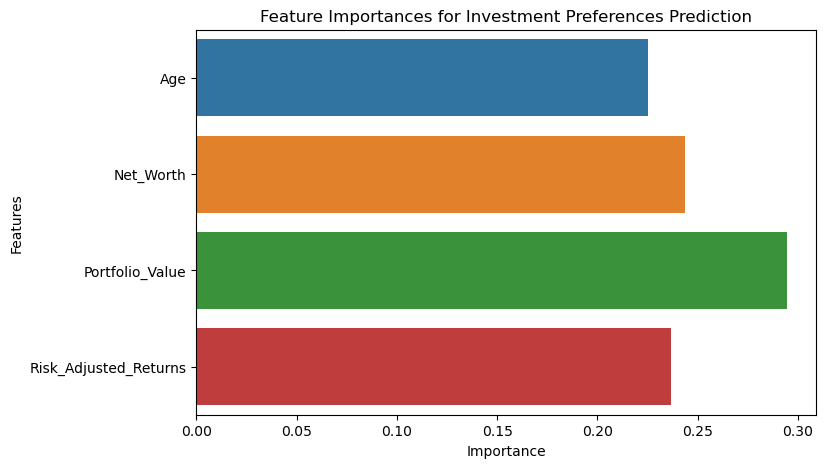

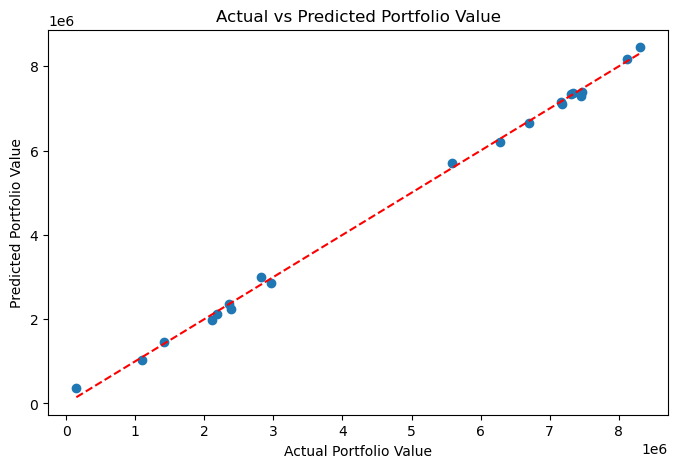

In [37]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


label_encoder = LabelEncoder()

correlation_data['Preferred_Investment'] = label_encoder.fit_transform(correlation_data['Preferred_Investment'])

# Define features (X) and target (y) for classification (Investment Preferences Prediction)
X = correlation_data[['Age', 'Net_Worth', 'Portfolio_Value', 'Risk_Adjusted_Returns']]
y = correlation_data['Preferred_Investment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)


print("Classification Report for Investment Preferences Prediction:")
print(classification_report(y_test, y_pred, zero_division=1))

# 2. Forecasting Portfolio Performance (Regression)



y_portfolio = correlation_data['Portfolio_Value']

# Split the data for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_portfolio, test_size=0.2, random_state=42)


rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_reg, y_train_reg)


y_pred_reg = rf_regressor.predict(X_test_reg)

# Evaluate the regression model
print("Mean Absolute Error for Portfolio Value Prediction:")
print(mean_absolute_error(y_test_reg, y_pred_reg))

# 3. Plot Feature Importances (Random Forest Model)

plt.figure(figsize=(8, 5))
sns.barplot(x=rf_classifier.feature_importances_, y=X.columns)
plt.title("Feature Importances for Investment Preferences Prediction")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

# 4. Plot Actual vs Predicted for Portfolio Value Prediction
plt.figure(figsize=(8, 5))
plt.scatter(y_test_reg, y_pred_reg)
plt.plot([min(y_test_reg), max(y_test_reg)], [min(y_test_reg), max(y_test_reg)], color='red', linestyle='--')
plt.title("Actual vs Predicted Portfolio Value")
plt.xlabel("Actual Portfolio Value")
plt.ylabel("Predicted Portfolio Value")
plt.show()


# Optimal Portfolio Allocation

Optimal Portfolio Weights: [0.18029943 0.48619969 0.33350089]
Expected Portfolio Return: 0.05005179298094829
Portfolio Risk (Standard Deviation): 0.06777809627445194


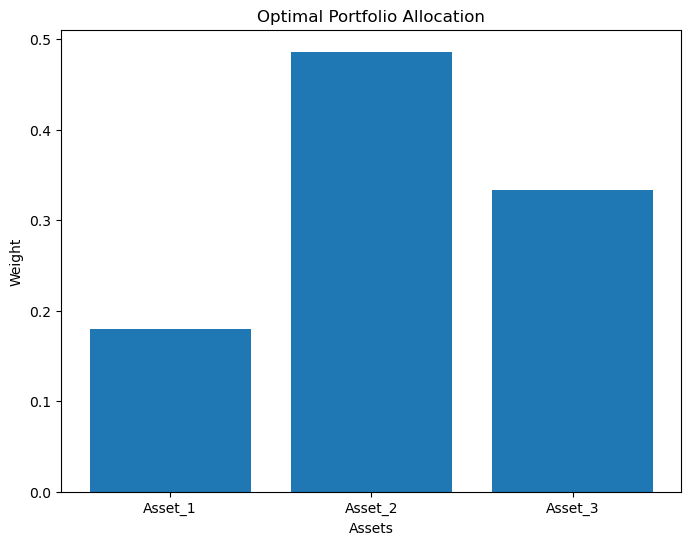

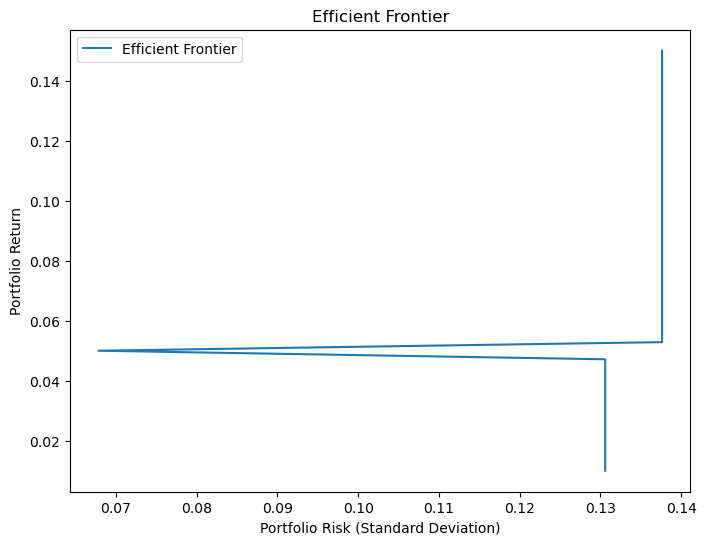

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Example data: Historical returns for a set of assets (e.g., stocks, bonds)
# Asset data: 3 assets with their returns

assets = ['Asset_1', 'Asset_2', 'Asset_3']
returns_data = {
    'Asset_1': np.random.normal(0.07, 0.15, 100),  
    'Asset_2': np.random.normal(0.05, 0.10, 100),  
    'Asset_3': np.random.normal(0.06, 0.12, 100)   
}


df = pd.DataFrame(returns_data)

# 1. Calculate expected returns and covariance matrix
expected_returns = df.mean()  
cov_matrix = df.cov()        

# 2. Define the objective function: Minimize portfolio risk (variance)
def portfolio_variance(weights, expected_returns, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# 3. Define constraints and bounds
num_assets = len(assets)


constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})


bounds = tuple((0, 1) for asset in range(num_assets))

# Initial guess: equally distributed weights
initial_guess = num_assets * [1. / num_assets]

# 4. Solve for optimal weights using a minimization algorithm (Markowitz)
optimal_solution = minimize(portfolio_variance, initial_guess, args=(expected_returns, cov_matrix),
                             method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal portfolio weights
optimal_weights = optimal_solution.x

# 5. Calculate expected portfolio return and risk (standard deviation)
portfolio_return = np.dot(optimal_weights, expected_returns)
portfolio_risk = np.sqrt(portfolio_variance(optimal_weights, expected_returns, cov_matrix))

print(f"Optimal Portfolio Weights: {optimal_weights}")
print(f"Expected Portfolio Return: {portfolio_return}")
print(f"Portfolio Risk (Standard Deviation): {portfolio_risk}")

# 6. Plotting the portfolio allocation
plt.figure(figsize=(8, 6))
plt.bar(assets, optimal_weights)
plt.title("Optimal Portfolio Allocation")
plt.xlabel("Assets")
plt.ylabel("Weight")
plt.show()

# 7. Risk-Return Trade-off: Plot Efficient Frontier

returns_range = np.linspace(0.01, 0.15, 50)  
risks = []

for target_return in returns_range:
    # Constraint: the expected portfolio return should match the target return
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}, 
                   {'type': 'eq', 'fun': lambda weights: np.dot(weights, expected_returns) - target_return})
    optimal_solution = minimize(portfolio_variance, initial_guess, args=(expected_returns, cov_matrix),
                                 method='SLSQP', bounds=bounds, constraints=constraints)
    risks.append(np.sqrt(portfolio_variance(optimal_solution.x, expected_returns, cov_matrix)))

# Plot Efficient Frontier
plt.figure(figsize=(8, 6))
plt.plot(risks, returns_range, label="Efficient Frontier")
plt.title("Efficient Frontier")
plt.xlabel("Portfolio Risk (Standard Deviation)")
plt.ylabel("Portfolio Return")
plt.legend()
plt.show()
